# Process to split lines into grid

In [2]:
# %load first_cell.py
%reload_ext autoreload
%autoreload 2
from pathlib import Path
import os

# system paths
import sys
home = str(Path.home())
sys.path = sys.path + [f'{home}/.conda/envs/norm_env/lib/python37.zip', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7/lib-dynload', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7/site-packages']
sys.prefix = '/home/soniame/.conda/envs/norm_env'
from paths import RAW_PATH, TREAT_PATH, OUTPUT_PATH, FIGURES_PATH

# aws connection*
import boto3
import awswrangler as wr

# local libraries
from src import utils

# analysis libraries
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import geopandas as gpd
import random
import itertools

import matplotlib.pyplot as plt

from shapely.geometry import box, Polygon, MultiPolygon, LineString, GeometryCollection, shape
from shapely import wkt
from shapely.ops import transform
from babelgrid import Babel

from multiprocessing.pool import Pool
from functools import partial

from loguru import logger

cm = str(datetime.today().strftime("%Y%m%d%H%m"))
cm

INFO|g|e|n|e|r|a|t|e|d| |n|e|w| |f|o|n|t|M|a|n|a|g|e|r


'202110010010'

## Sample dates

Executing 50 dates to sample from jams data set

In [ ]:
from src.runners.sample_jams import _sample_dates

In [ ]:
df = _sample_dates(start_date = '2019-01-01', end_date = '2021-08-12')

In [ ]:
print(df.date_filter[0])

## Sample lines counts

Run a query to download unique lines and number of appearance. 

- Lines 21,904,128
- Jams 507,139,112
- 50 weekdays sampled

Data is split in 6 groups to run each intersection with grids. Function `_split_groups()`. Each split contains 3,650,688 lines.

In [3]:
from src.runners.split_polygon import _get_lines

In [ ]:
df_lines = _get_lines(update_data = False)

In [ ]:
print(df_lines.shape)
print(sum(df_lines.count_lines))
df_lines.head(3)

In [ ]:
from siuba import group_by, summarize, _
(df_lines
  >> group_by(_.split)
  >> summarize(lines = _.line_wkt.count())
  )

## Coarse grid split

In [20]:
from src.runners import split_polygon

In [ ]:
# Plotting H3 cells

# H3 cells grid
tiles = Babel('h3').polyfill(geometry, resolution=1)
# S2 cells grid
#tiles = Babel('s2').polyfill(geometry, resolution=4)
len(tiles)

if False:
    tiles_gdf = gpd.GeoDataFrame([t.to_dict() for t in tiles], geometry='shapely')
    df = tiles_gdf
    m = folium.Map(location=[40.70, -73.94], zoom_start=2, tiles='CartoDB positron')
    for _, r in df.iterrows():
        # Without simplifying the representation of each borough,
        # the map might not be displayed
        sim_geo = gpd.GeoSeries(r['shapely']).simplify(tolerance=0.001)
        geo_j = sim_geo.to_json()
        geo_j = folium.GeoJson(data=geo_j,
                               style_function=lambda x: {'fillColor': 'orange'})
        geo_j.add_to(m)
    m

In [ ]:
tiles[0].geometry.wkt

In [ ]:
# Run this in 6 separated instances 
logger.warning('Better to run it from terminal in different instances')
# df_coarse_split = _create_coarse_grid(df_lines, tiles, split = )

### Coarse grid union

Union of results from parallelization in 6 instances. 

- Cells: 57
- Lines: 22,214,341
- Run time per instance: 3 hrs.

In [ ]:
from src.runners.split_polygon import _coarse_union

In [ ]:
mypath = "/home/soniame/private/projects/corona_geo_id/coarse_grid/"
csv_files = [os.path.join(mypath, x) for x in os.listdir(mypath)]

In [ ]:
# Sample: union of lines
csv_files = ['/home/soniame/private/projects/corona_geo_id/coarse_grid/coarse_id.csv',
 '/home/soniame/private/projects/corona_geo_id/coarse_grid/coarse_id_new_1.csv',
 '/home/soniame/private/projects/corona_geo_id/coarse_grid/coarse_id_new_2.csv',
 '/home/soniame/private/projects/corona_geo_id/coarse_grid/coarse_id_new_3.csv',
 '/home/soniame/private/projects/corona_geo_id/coarse_grid/coarse_id_new_4.csv',
 '/home/soniame/private/projects/corona_geo_id/coarse_grid/coarse_id_new_5.csv',
 '/home/soniame/private/projects/corona_geo_id/coarse_grid/coarse_id_new_6.csv']
csv_files
df_coarse = _coarse_union(csv_files)

In [ ]:
# Export to csv 
coarse_path = '/home/soniame/shared/spd-sdv-omitnik-waze/corona/geo_partition/coarse_id/coarse_grid_sample.csv'
df_coarse.to_csv(coarse_path, index = False)

### Coarse grid distribution

In [ ]:
coarse_path = '/home/soniame/shared/spd-sdv-omitnik-waze/corona/geo_partition/coarse_id/coarse_grid_sample.csv'
df_coarse_R1 = pd.read_csv(coarse_path)
df_coarse_R1 = df_coarse_R1.rename(columns = {'line':'line_wkt'})

In [ ]:
print(df_coarse_R1.shape)
print(df_coarse_R1.coarse_wkt.nunique())
print(df_coarse_R1.line_wkt.nunique())
# df_coarse_R1.head()

In [ ]:
# Union de coarse y merge con count of jams
df_merge = df_coarse_R1.merge(df_lines, how = 'left', on = 'line_wkt')
print(df_merge.shape)
df_merge.head()

In [ ]:
from siuba import group_by, ungroup, arrange, summarize, _

# Table of distribution pero H3 Cell
tab = (df_merge
  >> group_by(_.coarse_wkt)
  >> summarize(lines = _.line_wkt.count(),
               jams  = _.count_lines.sum())
  >> ungroup()
  >> arrange(-_.lines)
  )
tab.head()

In [ ]:
# Export to csv 
tab.to_csv('/home/soniame/shared/spd-sdv-omitnik-waze/corona/geo_partition/figures/coarse_grid_distribution.csv', index = False)

Plots

In [ ]:
tab = pd.read_csv('/home/soniame/shared/spd-sdv-omitnik-waze/corona/geo_partition/figures/coarse_grid_distribution.csv')

In [ ]:
tab['geometry'] = gpd.GeoSeries.from_wkt(tab['coarse_wkt'])
tab = gpd.GeoDataFrame(tab, geometry='geometry')
fig, ax = plt.subplots(1, 1)
tab.plot(column='lines', ax=ax, 
         legend=True, cmap='OrRd')
plt.title('Coarse Grid 1 - Number of lines')
plt.savefig('/home/soniame/shared/spd-sdv-omitnik-waze/corona/geo_partition/figures/coarse_map_LinesR1.pdf')

In [ ]:
tab['geometry'] = gpd.GeoSeries.from_wkt(tab['coarse_wkt'])
tab = gpd.GeoDataFrame(tab, geometry='geometry')
fig, ax = plt.subplots(1, 1)
tab.plot(column='jams', ax=ax, 
         legend=True, cmap='OrRd')
plt.title('Coarse Grid 1 - Number of Jams')
plt.savefig('/home/soniame/shared/spd-sdv-omitnik-waze/corona/geo_partition/figures/coarse_map_JamsR1.pdf')

In [ ]:
plt.scatter(tab.jams, tab.lines)

### Coarse grid union Big Polygons (R2)

Union of results from parallelization in 6 instances. 

- Cells: 
- Lines: 22,214,341
- Run time per polygon: 2 hrs.

In [ ]:
from src.runners.split_polygon import _new_res_coarse_grid
from siuba import group_by, ungroup, arrange, summarize, _

In [ ]:
# Ran in terminal
logger.warning("Only run to update resolution 2")
# _new_res_coarse_grid()

In [ ]:
from src.runners.split_polygon import _coarse_union
mypath = "/home/soniame/private/projects/corona_geo_id/coarse_grid/"
csv_files = [os.path.join(mypath, x) for x in os.listdir(mypath)]

In [ ]:
# Sample: union of lines for resolution 2
csv_files = [
 '/home/soniame/private/projects/corona_geo_id/coarse_grid/coarse_id_new_R2_1.csv',
 '/home/soniame/private/projects/corona_geo_id/coarse_grid/coarse_id_new_R2_2.csv',
 '/home/soniame/private/projects/corona_geo_id/coarse_grid/coarse_id_new_R2_3.csv',
 '/home/soniame/private/projects/corona_geo_id/coarse_grid/coarse_id_new_R2_4.csv',
 '/home/soniame/private/projects/corona_geo_id/coarse_grid/coarse_id_new_R2_5.csv',
 '/home/soniame/private/projects/corona_geo_id/coarse_grid/coarse_id_new_R2_6.csv']
csv_files
df_coarse_R2 = _coarse_union(csv_files)
df_coarse_R2 = df_coarse_R2.rename(columns={'coarse_wkt':'coarse_wkt_2', 'line':'line_wkt'})

In [ ]:
print(len(df_coarse_R2))
print(len(df_coarse_R1))
print(len(df_lines))

In [ ]:
df_coarse_R2.head()

In [ ]:
tab = pd.read_csv('/home/soniame/shared/spd-sdv-omitnik-waze/corona/geo_partition/figures/coarse_grid_distribution.csv')
bp = tab.sort_values('lines', ascending=False)[:6][['coarse_wkt']]
bp['bp'] = [1, 2, 3, 4, 5, 6]

In [ ]:
# Union of previous coarse_wkt, big polygons and line jams
# Merge of coarse wkt R1 and R2
df_coarse_R = df_lines.\
     merge(df_coarse_R1, how = 'left', on = 'line_wkt'). \
     merge(df_coarse_R2, how = 'left', on = 'line_wkt'). \
     merge(bp, how = 'left', on = 'coarse_wkt'). \
     drop_duplicates()
 
print(len(df_coarse_R))
#df_coarse_R.head()

In [ ]:
# Replace nulls for values
df_coarse_R['coarse_wkt_R'] = np.where(df_coarse_R['bp'].isna(), 
                                       df_coarse_R['coarse_wkt'], 
                                       df_coarse_R['coarse_wkt_2'])
print(sum(df_coarse_R['coarse_wkt_R'].isna()))

df_coarse_R['coarse_wkt_R'] = np.where(df_coarse_R['coarse_wkt_R'].isna(), 
                                       '(MISSING)', 
                                       df_coarse_R['coarse_wkt_R'])
print(sum(df_coarse_R['coarse_wkt_R'].isna()))

In [ ]:
# Table of distribution pero wkt union
#df_dist = (df_coarse_R
#  >> group_by(_.coarse_wkt_R)
#  >> summarize(lines = _.line_wkt.count(),
#               jams  = _.count_lines.sum(), 
#               bp = _.bp.max())
#  >> ungroup()
#  >> arrange(-_.lines)
#  )
#min_wkt = str(df_dist.sort_values('lines', ascending=True)[:1].coarse_wkt_R)

In [ ]:
# Export to csv 
coarse_R_path = '/home/soniame/shared/spd-sdv-omitnik-waze/corona/geo_partition/coarse_id/coarse_grid_sample_R2.csv'
df_coarse_R[['line_wkt', 'count_lines', 'bp', 'coarse_wkt_R']].to_csv(coarse_R_path, index = False)

### Coarse grid distribution Big Polygons

In [ ]:
from siuba import group_by, ungroup, arrange, summarize, _

In [ ]:
df_coarse_R = pd.read_csv(coarse_R_path)

In [ ]:
print(df_coarse_R.shape)
print(df_coarse_R.coarse_wkt_R.nunique())
print(df_coarse_R.line_wkt.nunique())
df_coarse_R.head()

In [ ]:
# Table of distribution pero wkt union
tab = (df_coarse_R
  >> group_by(_.coarse_wkt_R)
  >> summarize(lines = _.line_wkt.count(),
               jams  = _.count_lines.sum(), 
               bp = _.bp.max())
  >> ungroup()
  >> arrange(-_.lines)
  )

In [ ]:
# Export to csv 
tab.to_csv('/home/soniame/shared/spd-sdv-omitnik-waze/corona/geo_partition/figures/coarse_grid_distribution_R.csv', index = False)

Plots

In [ ]:
tab = pd.read_csv('/home/soniame/shared/spd-sdv-omitnik-waze/corona/geo_partition/figures/coarse_grid_distribution_R.csv')

In [ ]:
tab = tab[tab.coarse_wkt_R != '(MISSING)']
tab['geometry'] = gpd.GeoSeries.from_wkt(tab['coarse_wkt_R'])
tab = gpd.GeoDataFrame(tab, geometry='geometry')
fig, ax = plt.subplots(1, 1)
tab.plot(column='lines', ax=ax, 
         legend=True, cmap='OrRd')
plt.title('Coarse Grid 1 - Number of lines')
plt.savefig('/home/soniame/shared/spd-sdv-omitnik-waze/corona/geo_partition/figures/coarse_map_LinesR2.pdf')

In [ ]:
fig, ax = plt.subplots(1, 1)
tab.plot(column='jams', ax=ax, 
         legend=True, cmap='OrRd')
plt.title('Coarse Grid 1 - Number of Jams')
plt.savefig('/home/soniame/shared/spd-sdv-omitnik-waze/corona/geo_partition/figures/coarse_map_JamsR2.pdf')

## Creating squares

In [56]:
from src.runners import split_polygon

In [ ]:
from shapely.geometry import box, Polygon, MultiPolygon, GeometryCollection
from shapely.wkt import loads

In [ ]:
# - Example 
# polygon = 'POLYGON((2.0117187499999822 44.38657313925715,-19.433593750000018 19.207272119703983,19.414062499999982 6.904449621538131,64.94140624999999 -3.096801256840523,81.46484374999999 37.21269961002643,45.78124999999998 24.106495997107682,53.69140624999998 51.22054369437158,3.7695312499999822 37.07257833232809,2.0117187499999822 44.38657313925715))'
# - Latin America 
# polygon = 'POLYGON ((-127.265625 34.30714385628804, -128.671875 -56.94497418085159, -28.4765625 -57.70414723434192, -29.8828125 16.97274101999902, -84.72656249999999 25.48295117535531, -116.71874999999999 35.746512259918504, -127.265625 34.30714385628804))'
# - Triángulo 
# polygon = Polygon([(0, 0), (5, 5), (5, 0)])
# - Peru
# polygon = 'POLYGON ((-77.10205078124999 -13.004557745339769, -72.158203125 -13.004557745339769, -72.158203125 -8.90678000752024, -77.10205078124999 -8.90678000752024, -77.10205078124999 -13.004557745339769))'
# - Latin america BID
polygon = 'POLYGON((-129.454 37.238,-90.781 27.311,-67.117 20.333,-68.721 17.506,-23.765 -9.114,-65.601 -60.714,-126.421 -23.479,-129.454 37.238))'
geometry = wkt.loads(polygon)
print(geometry.area)
#geometry

In [ ]:
#df_lines = split_polygon._get_lines()

In [57]:
df_coarse = split_polygon._get_coarse_grid()

2021-10-01 01:29:01.662 | INFO     | src.runners.split_polygon:_get_coarse_grid:200 - Get coarse grid
2021-10-01 01:29:01.663 | DEBUG    | src.runners.split_polygon:_get_coarse_grid:202 - From /home/soniame/shared/spd-sdv-omitnik-waze/corona/geo_partition/coarse_id/coarse_grid_sample_R2.csv
2021-10-01 01:30:48.856 | DEBUG    | src.runners.split_polygon:_get_coarse_grid:206 - L: 21904128


In [25]:
df_dist = split_polygon._get_dist_table()

2021-09-13 13:55:42.056 | INFO     | src.runners.split_polygon:_get_dist_table:201 - Get distribution table
2021-09-13 13:55:42.142 | DEBUG    | src.runners.split_polygon:_get_dist_table:205 - G: 91


In [28]:
print(len(df_coarse))
print(len(df_dist))

21904128
91


In [ ]:
#_threshold_density_func(geometry, .01, df_dist, df_coarse)

In [29]:
print(df_dist.shape)
print(df_coarse.shape)

(91, 4)
(21904128, 4)


In [ ]:
df_coarse[df_coarse.coarse_wkt_R == '(MISSING)'].to_csv("/home/soniame/shared/spd-sdv-omitnik-waze/corona/geo_partition/figures/missing_ids.csv")

In [ ]:
df_coarse[df_coarse.coarse_wkt_R == '(MISSING)'].head()

## Lines intersection per square



In [ ]:
pd.DataFrame

In [147]:
cm_read = '2021083013081630344071'
mypath = f"/home/soniame/shared/spd-sdv-omitnik-waze/corona/geo_partition/geo_id/{cm_read}"
geo_id_path = max([os.path.join(mypath, x) for x in os.listdir(mypath)])
print(geo_id_path)
df_geo_id = pd.read_csv(geo_id_path)
print(len(df_geo_id.geometry.unique()))
df_geo_id.head()

/home/soniame/shared/spd-sdv-omitnik-waze/corona/geo_partition/geo_id/2021083013081630344071/geo_grid_area_2021083013081630344071.csv
364


,Unnamed: 0,geometry
0,0,POLYGON ((-101.8926651563943 -38.4956482719772...
1,1,"POLYGON ((-76.6095 -31.17131201701743, -76.609..."
2,2,POLYGON ((-89.25108257819717 -31.1713120170174...
3,3,"POLYGON ((-76.6095 -19.76976001418119, -76.609..."
4,4,POLYGON ((-82.93029128909859 -19.7697600141811...


In [148]:
geopath = "/home/soniame/private/projects/corona_geo_id/geo_id/"
geo_id_path = [os.path.join(geopath, x) for x in os.listdir(geopath)][1:]
geo_id_path
df_geo_lines = pd.DataFrame()
for pth in geo_id_path:
    print(pth)
    df_geo_lines = df_geo_lines.append(pd.read_csv(pth))
df_geo_lines = df_geo_lines \
    .rename(columns = {'wkt_def':'line_wkt', 'geom_def':'geo_id'})    
df_geo_lines = df_geo_lines[['line_wkt', 'geo_id']].groupby('line_wkt').first().reset_index()

/home/soniame/private/projects/corona_geo_id/geo_id/results_0.csv
/home/soniame/private/projects/corona_geo_id/geo_id/results_1.csv
/home/soniame/private/projects/corona_geo_id/geo_id/results_10.csv
/home/soniame/private/projects/corona_geo_id/geo_id/results_100.csv
/home/soniame/private/projects/corona_geo_id/geo_id/results_101.csv
/home/soniame/private/projects/corona_geo_id/geo_id/results_102.csv
/home/soniame/private/projects/corona_geo_id/geo_id/results_103.csv
/home/soniame/private/projects/corona_geo_id/geo_id/results_104.csv
/home/soniame/private/projects/corona_geo_id/geo_id/results_105.csv
/home/soniame/private/projects/corona_geo_id/geo_id/results_106.csv
/home/soniame/private/projects/corona_geo_id/geo_id/results_107.csv
/home/soniame/private/projects/corona_geo_id/geo_id/results_108.csv
/home/soniame/private/projects/corona_geo_id/geo_id/results_109.csv
/home/soniame/private/projects/corona_geo_id/geo_id/results_11.csv
/home/soniame/private/projects/corona_geo_id/geo_id/re

/home/soniame/private/projects/corona_geo_id/geo_id/results_207.csv
/home/soniame/private/projects/corona_geo_id/geo_id/results_208.csv
/home/soniame/private/projects/corona_geo_id/geo_id/results_209.csv
/home/soniame/private/projects/corona_geo_id/geo_id/results_21.csv
/home/soniame/private/projects/corona_geo_id/geo_id/results_210.csv
/home/soniame/private/projects/corona_geo_id/geo_id/results_211.csv
/home/soniame/private/projects/corona_geo_id/geo_id/results_212.csv
/home/soniame/private/projects/corona_geo_id/geo_id/results_213.csv
/home/soniame/private/projects/corona_geo_id/geo_id/results_214.csv
/home/soniame/private/projects/corona_geo_id/geo_id/results_215.csv
/home/soniame/private/projects/corona_geo_id/geo_id/results_216.csv
/home/soniame/private/projects/corona_geo_id/geo_id/results_217.csv
/home/soniame/private/projects/corona_geo_id/geo_id/results_218.csv
/home/soniame/private/projects/corona_geo_id/geo_id/results_219.csv
/home/soniame/private/projects/corona_geo_id/geo_

/home/soniame/private/projects/corona_geo_id/geo_id/results_316.csv
/home/soniame/private/projects/corona_geo_id/geo_id/results_317.csv
/home/soniame/private/projects/corona_geo_id/geo_id/results_318.csv
/home/soniame/private/projects/corona_geo_id/geo_id/results_319.csv
/home/soniame/private/projects/corona_geo_id/geo_id/results_32.csv
/home/soniame/private/projects/corona_geo_id/geo_id/results_320.csv
/home/soniame/private/projects/corona_geo_id/geo_id/results_321.csv
/home/soniame/private/projects/corona_geo_id/geo_id/results_322.csv
/home/soniame/private/projects/corona_geo_id/geo_id/results_323.csv
/home/soniame/private/projects/corona_geo_id/geo_id/results_324.csv
/home/soniame/private/projects/corona_geo_id/geo_id/results_325.csv
/home/soniame/private/projects/corona_geo_id/geo_id/results_326.csv
/home/soniame/private/projects/corona_geo_id/geo_id/results_327.csv
/home/soniame/private/projects/corona_geo_id/geo_id/results_328.csv
/home/soniame/private/projects/corona_geo_id/geo_

In [183]:
print(df_geo_lines.shape)
print(df_geo_lines.geo_id.nunique())
print(df_geo_lines.line_wkt.nunique())

(20951328, 2)
259
20951328


In [184]:
print(df_coarse.shape)
print(df_geo_lines.shape)

(21904128, 4)
(20951328, 2)


In [185]:
df = df_geo_lines.merge(df_coarse[['line_wkt', 'count_lines']].rename(columns = {'count_lines':'jams'}), how = 'right')
print(df.shape)
df.head()

(21904128, 3)


,line_wkt,geo_id,jams
0,"LINESTRING(-100.000017 19.255754, -99.99994 19...","POLYGON ((-103.03175 18.3231969633793, -103.03...",6
1,"LINESTRING(-100.000019 20.386056, -100.000242 ...","POLYGON ((-103.03175 18.3231969633793, -103.03...",2
2,"LINESTRING(-100.000019 20.386056, -100.000242 ...","POLYGON ((-103.03175 18.3231969633793, -103.03...",4
3,"LINESTRING(-100.000019 20.386056, -100.000242 ...","POLYGON ((-103.03175 18.3231969633793, -103.03...",2
4,"LINESTRING(-100.000019 20.386056, -100.000242 ...","POLYGON ((-103.03175 18.3231969633793, -103.03...",4


In [188]:
print(df.line_wkt.nunique())
print(df.geo_id.nunique())

21904128
259


In [189]:
df.geo_id.unique()

array(['POLYGON ((-103.03175 18.3231969633793, -103.03175 20.74968832471787, -99.72896875000001 20.74968832471787, -99.72896875000001 18.3231969633793, -103.03175 18.3231969633793))',
       'POLYGON ((-103.03175 23.17617968605644, -103.03175 25.60267104739501, -99.72896875000001 25.60267104739501, -99.72896875000001 23.17617968605644, -103.03175 23.17617968605644))',
       'POLYGON ((-99.72896875000001 20.74968832471787, -103.03175 20.74968832471787, -103.03175 23.17617968605644, -99.72896875000001 23.17617968605644, -99.72896875000001 20.74968832471787))',
       'POLYGON ((-99.72896875000001 28.02916240873358, -99.72896875000001 25.60267104739501, -103.03175 25.60267104739501, -103.03175 28.02916240873358, -99.72896875000001 28.02916240873358))',
       'POLYGON ((-103.03175 15.89670560204073, -103.03175 18.3231969633793, -99.72896875000001 18.3231969633793, -99.72896875000001 15.89670560204073, -103.03175 15.89670560204073))',
       'POLYGON ((-103.03175 30.45565377007214, -99.72

In [196]:
path_s3 = '/home/soniame/shared/spd-sdv-omitnik-waze/corona'
df[['line_wkt', 'geo_id', 'jams']].to_csv(f'{path_s3}/geo_partition/geo_lines/2021083013081630344071.csv')

### Distribution of lines/jams per square

In [207]:
from siuba import group_by, ungroup, arrange, summarize, _
import geopandas as gpd
#import folium

In [190]:
tab = (df
  >> group_by(_.geo_id)
  >> summarize(lines = _.line_wkt.count(), 
               jams = _.jams.sum())
  >> ungroup()
  >> arrange("jams")
  )
tab['geometry'] = gpd.GeoSeries.from_wkt(tab['geo_id'])
tab = gpd.GeoDataFrame(tab, geometry='geometry')

print(tab.shape)
tab.head()

(259, 4)


,geo_id,lines,jams,geometry
201,"POLYGON ((-73.30671875 2.170599169624747, -70....",5,9,"POLYGON ((-73.30672 2.17060, -70.00394 2.17060..."
232,"POLYGON ((-83.2150625 -8.368208011344954, -89....",7,15,"POLYGON ((-83.21506 -8.36821, -89.82063 -8.368..."
258,POLYGON ((-99.72896875000001 29.60786049133116...,2,21,"POLYGON ((-99.72897 29.60786, -96.42619 28.760..."
150,POLYGON ((-62.54741185860617 -18.7909338869168...,20,35,"POLYGON ((-62.54741 -18.79093, -59.73499 -18.7..."
80,POLYGON ((-48.48532371721236 -29.1973362403338...,15,58,"POLYGON ((-48.48532 -29.19734, -48.48532 -27.4..."


In [195]:
#tab.to_csv("/home/soniame/shared/spd-sdv-omitnik-waze/corona/geo_partition/figures/geo_lines_distribution.csv", index=False)
#tab.to_csv(f"/home/soniame/shared/spd-sdv-omitnik-waze/corona/geo_partition/dist/distribution_2021083013081630344071.csv", index=False)

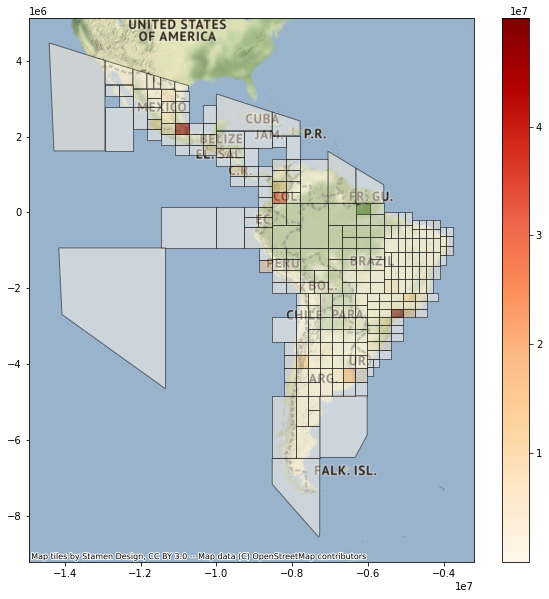

In [194]:
import matplotlib.pyplot as plt
import contextily as ctx

pdf_path = f"/home/soniame/shared/spd-sdv-omitnik-waze/corona/geo_partition/figures/map_distribution_2021083013081630344071.pdf"
with PdfPages(pdf_path) as pdf:
    tab = gpd.GeoDataFrame(tab, geometry='geometry')
    tab['geometry'] = gpd.GeoSeries.from_wkt(tab['geo_id'])
    tab.crs = "EPSG:4326"
    tab = tab.to_crs(epsg=3857)
    ax = tab.plot(figsize=(10, 10), alpha=0.5, edgecolor='k', 
                column='jams',legend=True, cmap='OrRd')

    ctx.add_basemap(ax)
    pdf.savefig()  


In [208]:
# FOLIUM CODE
#df = tab
#m = folium.Map(location=[-24.1792320824178, -60.97559398552432], zoom_start=2, tiles='CartoDB positron')
#for _, r in df.iterrows():
#    # Without simplifying the representation of each borough,
#    # the map might not be displayed
#    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
#    geo_j = sim_geo.to_json()
#    geo_j = folium.GeoJson(data=geo_j,
#                           style_function=lambda x: {'fillColor': 'orange'})
#    folium.Popup(r['lines']).add_to(geo_j)
#    geo_j.add_to(m)
#m

In [ ]:
tab = pd.read_csv(f"/home/soniame/shared/spd-sdv-omitnik-waze/corona/geo_partition/dist/distribution_{config['cm_read']}.csv")
logger.debug(f"UP: {tab.geo_id.nunique()}")

# Polygon geometry definition
ratio = tab \
    .sort_values('jams', ascending=False) \
    .assign(ratio = lambda x: x.jams /(sum(df_coarse.count_lines)*.01))
logger.debug(f"Total .01 {(sum(df_coarse.count_lines)*.01)}")

## Ratio big squares

In [110]:
tab = pd.read_csv("/home/soniame/shared/spd-sdv-omitnik-waze/corona/geo_partition/figures/geo_lines_distribution.csv")
tab['geometry'] = gpd.GeoSeries.from_wkt(tab['geo_id'])
tab = gpd.GeoDataFrame(tab, geometry='geometry')
tab.head()

,geo_id,lines,jams,geometry
0,"POLYGON ((-73.30671875 2.170599169624747, -70....",5,9,"POLYGON ((-73.30672 2.17060, -70.00394 2.17060..."
1,"POLYGON ((-83.2150625 -8.368208011344954, -89....",7,15,"POLYGON ((-83.21506 -8.36821, -89.82063 -8.368..."
2,POLYGON ((-62.54741185860617 -18.7909338869168...,20,35,"POLYGON ((-62.54741 -18.79093, -59.73499 -18.7..."
3,"POLYGON ((-73.30671875 -8.310167358646043, -70...",3,101,"POLYGON ((-73.30672 -8.31017, -70.00394 -8.310..."
4,"POLYGON ((-56.7928125 -8.310167358646043, -60....",8,106,"POLYGON ((-56.79281 -8.31017, -60.09559 -8.310..."


In [205]:
print(df_coarse.count_lines.sum())
print(df_dist.jams.sum())

507139112
507139112


In [201]:
ratio = tab \
    .sort_values('jams', ascending=False) \
    .assign(ratio = lambda x: x.jams / (sum(df_dist.jams)*.01))
ratio[ratio.ratio > 2]

,geo_id,lines,jams,geometry,ratio
258,POLYGON ((-48.48532371721236 -23.9941350636253...,1960715,49964198,POLYGON ((-5397361.54714711 -2752693.457620558...,9.852168
257,POLYGON ((-99.72896875000001 20.74968832471787...,1593700,47059421,POLYGON ((-11101778.01858829 2362056.499358989...,9.279391
256,"POLYGON ((-73.30671875 2.170599169624747, -76....",863874,29708529,"POLYGON ((-8160466.602975721 241687.813129794,...",5.858063
255,POLYGON ((-59.73499423032741 -37.1322753113907...,789442,20138924,POLYGON ((-6649669.140259182 -4457560.33255264...,3.971085
254,POLYGON ((-42.86048846065484 -22.2597346713891...,648861,17859681,POLYGON ((-4771207.750591075 -2542738.18254934...,3.521653
253,"POLYGON ((-76.6095 -11.21859601205401, -76.609...",451296,14595396,POLYGON ((-8528130.529927291 -1256905.50735726...,2.877987
252,POLYGON ((-45.6729060889336 -18.79093388691683...,481445,14352943,POLYGON ((-5084284.648869093 -2130337.16335246...,2.830179
251,POLYGON ((-68.1722471151637 -31.89189204725532...,653467,13277755,POLYGON ((-7588899.835093237 -3749128.12914092...,2.618168
250,"POLYGON ((-76.6095 4.790790801692445, -76.6095...",475080,12568601,POLYGON ((-8528130.529927291 533930.9168105632...,2.478334
249,"POLYGON ((-103.03175 21.71437007834323, -103.0...",393476,10292380,POLYGON ((-11469441.94553986 2477266.300620793...,2.029498


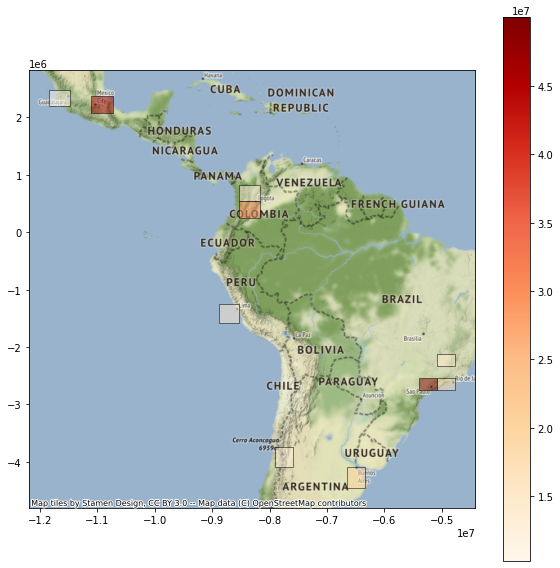

In [74]:
df_wm = ratio[ratio.ratio > 2]
df_wm.crs = "EPSG:4326"
df_wm = df_wm.to_crs(epsg=3857)
ax = df_wm.plot(figsize=(10, 10), alpha=0.5, edgecolor='k', 
                column='jams',legend=True, cmap='OrRd')
ctx.add_basemap(ax)

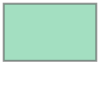

In [132]:
squares = ratio[ratio.ratio > 2]
len(squares)
polygon = squares.geo_id.tolist()[0]
polygon
geometry = wkt.loads(polygon)
geometry

## Re do of squares

In [129]:
#os.listdir(mypath)
#from src.runners.split_polygon import _get_dist_table, _get_coarse_grid, _lines_squares
from siuba import group_by, ungroup, arrange, summarize, _
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import contextily as ctx



In [144]:
def _lines_join(config):
    cm_read = '2021091413091631639640'
    path_s3 ='/home/soniame/shared/spd-sdv-omitnik-waze/corona'
    path_dir = f"{path_s3}/geo_partition/geo_lines/{cm_read}"
    paths_read = [os.path.join(path_dir, x) for x in os.listdir(path_dir)]
    df_geo_lines = pd.DataFrame()
    for path in paths_read:
        print(path)
        if path.endswith('.csv'):
            try:
                df = pd.read_csv(path)
                print(df.shape)
                df_geo_lines = df_geo_lines.append(df)
            except:  
                print ("Zero Division Exception Raised." )

    df_geo_lines = df_geo_lines \
        .rename(columns = {'wkt_def':'line_wkt', 'geom_def':'geo_id'})    
    df_geo_lines.head()
    df = df_geo_lines.merge(df_coarse[['line_wkt', 'count_lines']].rename(columns = {'count_lines':'jams'}))

    return(df_geo_lines)

def _distribution_tab(df):

    tab = (df
      >> group_by(_.geo_id)
      >> summarize(lines = _.line_wkt.count(), 
                   jams = _.jams.sum())
      >> ungroup()
      >> arrange("jams")
      )
    tab['geometry'] = gpd.GeoSeries.from_wkt(tab['geo_id'])
    tab = gpd.GeoDataFrame(tab, geometry='geometry')

    print(tab.shape)
    
    return(tab)

def _distribution_map(tab):

    s3_path = 's3://iadbprod-public-stata-as-a-service/spd-sdv-omitnik-waze/corona'
    #'/home/soniame/shared/spd-sdv-omitnik-waze/corona'
    pdf_path = f'{s3_path}/geo_partition/figures/map_distribution_{cm_read}.pdf'
    with PdfPages(pdf_path) as pdf:
        tab = gpd.GeoDataFrame(tab, geometry='geometry')
        tab['geometry'] = gpd.GeoSeries.from_wkt(tab['geo_id'])
        tab.crs = "EPSG:4326"
        tab = tab.to_crs(epsg=3857)
        ax = tab.plot(figsize=(10, 10), alpha=0.5, edgecolor='k',legend=True, cmap='OrRd')
        ctx.add_basemap(ax)
        pdf.savefig()  

        
def _density_lines_figures(config):
    
    # Coarse grid ----
    df_coarse = _get_coarse_grid()
    
    # Lines 
    df = _lines_join(config)
    
    # Table
    tab = _distribution_tab(df)
    
    # Map
    _distribution_map(tab)
    

In [95]:

df_geo_lines = _lines_join()
df_geo_lines = df_geo_lines \
    .rename(columns = {'wkt_def':'line_wkt', 'geom_def':'geo_id'})    
df_geo_lines.head()
df = df_geo_lines.merge(df_coarse[['line_wkt', 'count_lines']].rename(columns = {'count_lines':'jams'}))


/home/soniame/shared/spd-sdv-omitnik-waze/corona/geo_partition/geo_lines/2021091413091631639640/results_0.csv
Zero Division Exception Raised.
/home/soniame/shared/spd-sdv-omitnik-waze/corona/geo_partition/geo_lines/2021091413091631639640/results_1.csv
(0, 2)
/home/soniame/shared/spd-sdv-omitnik-waze/corona/geo_partition/geo_lines/2021091413091631639640/results_10.csv
(0, 2)
/home/soniame/shared/spd-sdv-omitnik-waze/corona/geo_partition/geo_lines/2021091413091631639640/results_100.csv
(3510, 2)
/home/soniame/shared/spd-sdv-omitnik-waze/corona/geo_partition/geo_lines/2021091413091631639640/results_101.csv
(3755, 2)
/home/soniame/shared/spd-sdv-omitnik-waze/corona/geo_partition/geo_lines/2021091413091631639640/results_102.csv
(6865, 2)
/home/soniame/shared/spd-sdv-omitnik-waze/corona/geo_partition/geo_lines/2021091413091631639640/results_103.csv
(33639, 2)
/home/soniame/shared/spd-sdv-omitnik-waze/corona/geo_partition/geo_lines/2021091413091631639640/results_104.csv
(108144, 2)
/home/soni

/home/soniame/shared/spd-sdv-omitnik-waze/corona/geo_partition/geo_lines/2021091413091631639640/results_16.csv
(220, 2)
/home/soniame/shared/spd-sdv-omitnik-waze/corona/geo_partition/geo_lines/2021091413091631639640/results_160.csv
(819, 2)
/home/soniame/shared/spd-sdv-omitnik-waze/corona/geo_partition/geo_lines/2021091413091631639640/results_161.csv
(0, 2)
/home/soniame/shared/spd-sdv-omitnik-waze/corona/geo_partition/geo_lines/2021091413091631639640/results_162.csv
(26083, 2)
/home/soniame/shared/spd-sdv-omitnik-waze/corona/geo_partition/geo_lines/2021091413091631639640/results_163.csv
(10741, 2)
/home/soniame/shared/spd-sdv-omitnik-waze/corona/geo_partition/geo_lines/2021091413091631639640/results_164.csv
(1196, 2)
/home/soniame/shared/spd-sdv-omitnik-waze/corona/geo_partition/geo_lines/2021091413091631639640/results_165.csv
(808, 2)
/home/soniame/shared/spd-sdv-omitnik-waze/corona/geo_partition/geo_lines/2021091413091631639640/results_166.csv
(110, 2)
/home/soniame/shared/spd-sdv-o

/home/soniame/shared/spd-sdv-omitnik-waze/corona/geo_partition/geo_lines/2021091413091631639640/results_220.csv
(0, 2)
/home/soniame/shared/spd-sdv-omitnik-waze/corona/geo_partition/geo_lines/2021091413091631639640/results_221.csv
(0, 2)
/home/soniame/shared/spd-sdv-omitnik-waze/corona/geo_partition/geo_lines/2021091413091631639640/results_222.csv
(0, 2)
/home/soniame/shared/spd-sdv-omitnik-waze/corona/geo_partition/geo_lines/2021091413091631639640/results_223.csv
(0, 2)
/home/soniame/shared/spd-sdv-omitnik-waze/corona/geo_partition/geo_lines/2021091413091631639640/results_224.csv
(1791, 2)
/home/soniame/shared/spd-sdv-omitnik-waze/corona/geo_partition/geo_lines/2021091413091631639640/results_225.csv
(0, 2)
/home/soniame/shared/spd-sdv-omitnik-waze/corona/geo_partition/geo_lines/2021091413091631639640/results_226.csv
(0, 2)
/home/soniame/shared/spd-sdv-omitnik-waze/corona/geo_partition/geo_lines/2021091413091631639640/results_227.csv
(0, 2)
/home/soniame/shared/spd-sdv-omitnik-waze/cor

/home/soniame/shared/spd-sdv-omitnik-waze/corona/geo_partition/geo_lines/2021091413091631639640/results_282.csv
(11298, 2)
/home/soniame/shared/spd-sdv-omitnik-waze/corona/geo_partition/geo_lines/2021091413091631639640/results_283.csv
(14099, 2)
/home/soniame/shared/spd-sdv-omitnik-waze/corona/geo_partition/geo_lines/2021091413091631639640/results_284.csv
(4162, 2)
/home/soniame/shared/spd-sdv-omitnik-waze/corona/geo_partition/geo_lines/2021091413091631639640/results_285.csv
(12618, 2)
/home/soniame/shared/spd-sdv-omitnik-waze/corona/geo_partition/geo_lines/2021091413091631639640/results_286.csv
(1595, 2)
/home/soniame/shared/spd-sdv-omitnik-waze/corona/geo_partition/geo_lines/2021091413091631639640/results_287.csv
(13681, 2)
/home/soniame/shared/spd-sdv-omitnik-waze/corona/geo_partition/geo_lines/2021091413091631639640/results_288.csv
(2736, 2)
/home/soniame/shared/spd-sdv-omitnik-waze/corona/geo_partition/geo_lines/2021091413091631639640/results_289.csv
(3496, 2)
/home/soniame/shared

/home/soniame/shared/spd-sdv-omitnik-waze/corona/geo_partition/geo_lines/2021091413091631639640/results_77.csv
(289721, 2)
/home/soniame/shared/spd-sdv-omitnik-waze/corona/geo_partition/geo_lines/2021091413091631639640/results_78.csv
(49309, 2)
/home/soniame/shared/spd-sdv-omitnik-waze/corona/geo_partition/geo_lines/2021091413091631639640/results_79.csv
(7139, 2)
/home/soniame/shared/spd-sdv-omitnik-waze/corona/geo_partition/geo_lines/2021091413091631639640/results_8.csv
(0, 2)
/home/soniame/shared/spd-sdv-omitnik-waze/corona/geo_partition/geo_lines/2021091413091631639640/results_80.csv
(3303, 2)
/home/soniame/shared/spd-sdv-omitnik-waze/corona/geo_partition/geo_lines/2021091413091631639640/results_81.csv
(11238, 2)
/home/soniame/shared/spd-sdv-omitnik-waze/corona/geo_partition/geo_lines/2021091413091631639640/results_82.csv
(7685, 2)
/home/soniame/shared/spd-sdv-omitnik-waze/corona/geo_partition/geo_lines/2021091413091631639640/results_83.csv
(22296, 2)
/home/soniame/shared/spd-sdv-om

In [146]:
df.shape()

TypeError: 'tuple' object is not callable

In [133]:
tab = _distribution_tab(df)

(247, 4)


In [145]:
_distribution_map(tab)

FileNotFoundError: [Errno 2] No such file or directory: 's3://iadbprod-public-stata-as-a-service/spd-sdv-omitnik-waze/corona/geo_partition/figures/map_distribution_2021091413091631639640.pdf'

In [132]:
cm_read = '2021091413091631639640'
tab.to_csv(f'/home/soniame/shared/spd-sdv-omitnik-waze/corona/geo_partition/dist/distribution_{cm_read}.csv', index=False)

In [200]:
tab = pd.read_csv(f"/home/soniame/shared/spd-sdv-omitnik-waze/corona/geo_partition/dist/distribution_{cm_read}.csv")
tab.geo_id.nunique()

259

In [141]:
df_coarse.count_lines.sum()


507139112

In [142]:
df_coarse.head()

,line_wkt,count_lines,bp,coarse_wkt_R
0,"linestring (-35.232974 -5.731801,-35.233194 -5...",26,NaN,POLYGON ((-32.5775356729615666 -12.75415506823...
1,"linestring (-103.34963 20.733682,-103.350022 2...",84,2.0,POLYGON ((-104.0069793612885434 17.72755605260...
2,"linestring (-103.270292 20.663531,-103.270276 ...",83,2.0,POLYGON ((-104.0069793612885434 17.72755605260...
3,"linestring (-99.14832 19.479112,-99.148334 19....",577,2.0,POLYGON ((-97.5919371226761996 18.289686316263...
4,"linestring (-47.221241 -22.858412,-47.221295 -...",71,1.0,POLYGON ((-46.3295683609798701 -25.28520383079...


## Union of squares

In [882]:
from src.runners.split_polygon import _union_df_squares
from matplotlib.backends.backend_pdf import PdfPages
import contextily as ctx
path_s3 = '/home/soniame/shared/spd-sdv-omitnik-waze/corona' 

### Union of distribution

In [679]:
path_s3 = '/home/soniame/shared/spd-sdv-omitnik-waze/corona' 
cm_read = ['2021083013081630344071', '2021091413091631639640', 
           '2021092812091632847410', '2021100101101633066162']

df_1 = _union_df_squares(path_s3, cm_read[0]) \
    .rename(columns = {'geometry':'polygon_1'})
df_2 = _union_df_squares(path_s3, cm_read[1]) \
    .rename(columns = {'polygon':'polygon_1', 'geometry':'polygon_2'})
df_3 = _union_df_squares(path_s3, cm_read[2]) \
    .rename(columns = {'polygon':'polygon_2', 'geometry':'polygon_3'})

union = df_1 \
    .merge(df_2, how = 'left', on='polygon_1') \
    .merge(df_3, how = 'left', on='polygon_2') \
    .reset_index()
union = union[['polygon_1', 'polygon_2', 'polygon_3']]
union['polygon_final'] = union['polygon_1']
union['polygon_final'].loc[union['polygon_2'].isnull()==False] = union['polygon_2'].loc[union['polygon_2'].isnull()==False]
union['polygon_final'].loc[union['polygon_3'].isnull()==False] = union['polygon_3'].loc[union['polygon_3'].isnull()==False] 

df_4 = _union_df_squares(path_s3, cm_read[3]) \
    .rename(columns = {'polygon':'polygon_final', 'geometry':'polygon_4'})
union = union \
    .merge(df_4, how = 'left', on='polygon_final') 
union['polygon_final'].loc[union['polygon_4'].isnull()==False] = union['polygon_4'].loc[union['polygon_4'].isnull()==False] 

dist = pd.DataFrame()
for c in cm_read:
    dist = dist.append(pd.read_csv(f"{path_s3}/geo_partition/dist/distribution_{c}.csv")) \
        [['geo_id', 'lines', 'jams']] 
    
dist_union = union \
    .merge(dist, right_on='geo_id', left_on='polygon_final') 
dist_union['share_jams'] = dist_union['jams']/507139112   
dist_union['ratio'] = dist_union['jams']/(507139112*.01)
dist.shape

2021-10-03 19:42:53.420 | DEBUG    | src.runners.split_polygon:_union_df_squares:531 - Paths: 1
2021-10-03 19:42:53.460 | DEBUG    | src.runners.split_polygon:_union_df_squares:541 - Sh: (364, 3)
2021-10-03 19:42:53.529 | DEBUG    | src.runners.split_polygon:_union_df_squares:531 - Paths: 11
2021-10-03 19:42:53.750 | DEBUG    | src.runners.split_polygon:_union_df_squares:541 - Sh: (297, 2)
2021-10-03 19:42:53.835 | DEBUG    | src.runners.split_polygon:_union_df_squares:531 - Paths: 6
2021-10-03 19:42:53.968 | DEBUG    | src.runners.split_polygon:_union_df_squares:541 - Sh: (21, 2)
2021-10-03 19:42:54.070 | DEBUG    | src.runners.split_polygon:_union_df_squares:531 - Paths: 13
2021-10-03 19:42:54.353 | DEBUG    | src.runners.split_polygon:_union_df_squares:541 - Sh: (205, 2)


(723, 3)

2021-10-03 19:42:58.050 | INFO     | __main__:<module>:1 - map


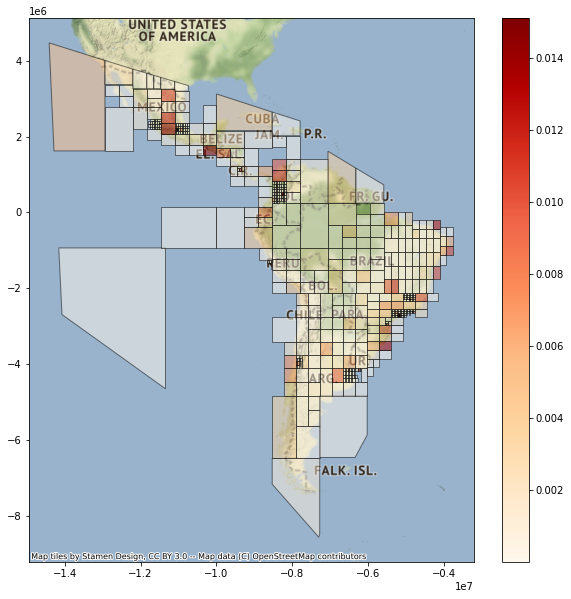

In [680]:
logger.info('map')
pdf_path = f"{path_s3}/geo_partition/figures/map_distribution_union_squares.pdf"
with PdfPages(pdf_path) as pdf:
    tab = gpd.GeoDataFrame(dist_union)
    tab['geometry'] = gpd.GeoSeries.from_wkt(tab['geo_id'])
    tab.crs = "EPSG:4326"
    tab = tab.to_crs(epsg=3857)
    ax = tab.plot(figsize=(10, 10), alpha=0.5, edgecolor='k', 
                  column='share_jams',legend=True, cmap='OrRd')
    ctx.add_basemap(ax)

In [672]:
print(dist_union.shape)
print(dist_union.sort_values(['polygon_1','polygon_2', 'polygon_3', 'polygon_4']).loc[dist_union['share_jams'] > .016].shape)


(694, 11)
(0, 11)


In [855]:
cm = '2021100301601633066162'
dist_union.to_csv(f"{path_s3}/geo_partition/dist/distribution_{cm}.csv", index=False)

### Ratio of jams

In [684]:
tab = pd.read_csv(f"{path_s3}/geo_partition/dist/distribution_{cm}.csv")[['geo_id', 'lines', 'jams']]
tab['geometry'] = gpd.GeoSeries.from_wkt(tab['geo_id'])
tab = gpd.GeoDataFrame(tab, geometry='geometry')

ratio = tab \
    .sort_values('jams', ascending=False) \
    .assign(ratio = lambda x: x.jams /(sum(df_coarse.count_lines)*.01))
logger.debug(f"Total .01 = {(sum(df_coarse.count_lines)*.01)}")
squares = ratio[ratio.ratio > 1.6]
logger.debug(f"Redo: {len(squares)}")

2021-10-03 19:45:13.782 | DEBUG    | __main__:<module>:8 - Total .01 = 5071391.12
2021-10-03 19:45:13.785 | DEBUG    | __main__:<module>:10 - Redo: 0


In [687]:
# Numbre of tab
if len(squares) > 0:
    tab = gpd.GeoDataFrame(squares)
    tab['geometry'] = gpd.GeoSeries.from_wkt(tab['geo_id'])
    tab.crs = "EPSG:4326"
    tab = tab.to_crs(epsg=3857)
    ax = tab.plot(figsize=(10, 10), alpha=0.5, edgecolor='k', 
                  column='ratio',legend=True, cmap='OrRd')
    ctx.add_basemap(ax)

### Grouping of squares

In [706]:
dist_union = pd.read_csv(f"{path_s3}/geo_partition/dist/distribution_{cm}.csv")
df = dist_union[['geo_id', 'lines', 'jams', 'share_jams']] \
    .assign(group = 0, 
            togroup = lambda x:x.share_jams < .016)

In [707]:
df_g = df
df_g = df_g[(df_g.group == 0)].sort_values(['geo_id', 'share_jams'])
df_final = pd.DataFrame()

i = 1
while len(df_g) > 0:
    logger.debug(f"{i} : {len(df_g)}")
    
    df_g = df_g.reset_index(drop = True)
    df_g['cumulative'] = df_g.share_jams.cumsum()
                
    if ((df_g['cumulative'].tolist()[0]) >= .015):
        df_g.loc[0, 'group'] = i
    else:
        df_g.loc[df_g.cumulative <= .015, 'group'] = i  
        
    df_final = df_final.append(df_g[(df_g.group != 0)])        
    
    i+=1
    df_g = df_g[(df_g.group == 0)]    

df_final.group = df_final.group.astype(str).str.pad(width=2, side='left', fillchar='0')    

2021-10-03 19:54:27.429 | DEBUG    | __main__:<module>:7 - 1 : 694
2021-10-03 19:54:27.436 | DEBUG    | __main__:<module>:7 - 2 : 691
2021-10-03 19:54:27.444 | DEBUG    | __main__:<module>:7 - 3 : 676
2021-10-03 19:54:27.451 | DEBUG    | __main__:<module>:7 - 4 : 651
2021-10-03 19:54:27.459 | DEBUG    | __main__:<module>:7 - 5 : 646
2021-10-03 19:54:27.466 | DEBUG    | __main__:<module>:7 - 6 : 644
2021-10-03 19:54:27.474 | DEBUG    | __main__:<module>:7 - 7 : 641
2021-10-03 19:54:27.482 | DEBUG    | __main__:<module>:7 - 8 : 639
2021-10-03 19:54:27.490 | DEBUG    | __main__:<module>:7 - 9 : 635
2021-10-03 19:54:27.498 | DEBUG    | __main__:<module>:7 - 10 : 621
2021-10-03 19:54:27.505 | DEBUG    | __main__:<module>:7 - 11 : 615
2021-10-03 19:54:27.513 | DEBUG    | __main__:<module>:7 - 12 : 614
2021-10-03 19:54:27.521 | DEBUG    | __main__:<module>:7 - 13 : 611
2021-10-03 19:54:27.528 | DEBUG    | __main__:<module>:7 - 14 : 604
2021-10-03 19:54:27.536 | DEBUG    | __main__:<module>:7 

In [708]:
print(df_final.shape)
print(df.shape)

(694, 7)
(694, 6)


In [709]:
figures = False
if (figures):
    df = gpd.GeoDataFrame(df_final)
    df['geometry'] = gpd.GeoSeries.from_wkt(df['geo_id'])
    df.crs = "EPSG:4326"
    df = df.to_crs(epsg=3857)
    ax = df.plot(figsize=(10, 10), alpha=0.5, edgecolor='k', 
                  column='group',legend=False, cmap='hot')
    ctx.add_basemap(ax)

### Convert to multipolygon

In [710]:
df_final.head()

,geo_id,lines,jams,share_jams,group,togroup,cumulative
0,POLYGON ((-101.8926651563943 -38.4956482719772...,206,937,0.000002,01,True,0.000002
1,"POLYGON ((-103.03175 15.89670560204073, -103.0...",26310,576298,0.001136,01,True,0.001138
2,"POLYGON ((-103.03175 18.3231969633793, -103.03...",321081,6900429,0.013607,01,True,0.014745
0,"POLYGON ((-103.03175 19.28787871700466, -103.0...",16622,235857,0.000465,02,True,0.000465
1,"POLYGON ((-103.03175 19.8945015573393, -103.03...",1790,23845,0.000047,02,True,0.000512


In [711]:
def polygon_to_multipolygon(strings):
    #strings = strings.tolist()
    new_strings = []
    for string in strings:
        new_strings.append(string.replace("POLYGON ", " "))
    
    new_string = 'MULTIPOLYGON (' + ', '.join(new_strings) + ')'

    return(new_string)

In [883]:
df_geo_partition = df_final \
    .groupby('group')\
    .geo_id.agg(polygon_to_multipolygon)\
    .reset_index()\
    .rename(columns={'geo_id':'geo_partition_wkt'}) \
    .merge(df_final \
               .groupby('group')\
               .share_jams.agg(sum)\
               .reset_index())
df_final.merge(df_geo_partition).head()
df_geo_partition

,group,geo_partition_wkt,share_jams
0,01,MULTIPOLYGON ( ((-101.8926651563943 -38.495648...,0.014745
1,02,"MULTIPOLYGON ( ((-103.03175 19.28787871700466,...",0.014869
2,03,MULTIPOLYGON ( ((-103.44459765625 20.501124397...,0.014803
3,04,MULTIPOLYGON ( ((-109.6373125 28.9938441623589...,0.008435
4,05,MULTIPOLYGON ( ((-33.67334375 -10.041085286949...,0.010849
...,...,...,...
74,75,MULTIPOLYGON ( ((-99.16130322265627 19.3089590...,0.012459
75,76,MULTIPOLYGON ( ((-99.21290917968751 19.4227008...,0.012718
76,77,MULTIPOLYGON ( ((-99.72896875000001 18.9298198...,0.006678
77,78,MULTIPOLYGON ( ((-99.72896875000001 20.7496883...,0.012649


2021-10-03 23:44:00.106 | INFO     | __main__:<module>:1 - map


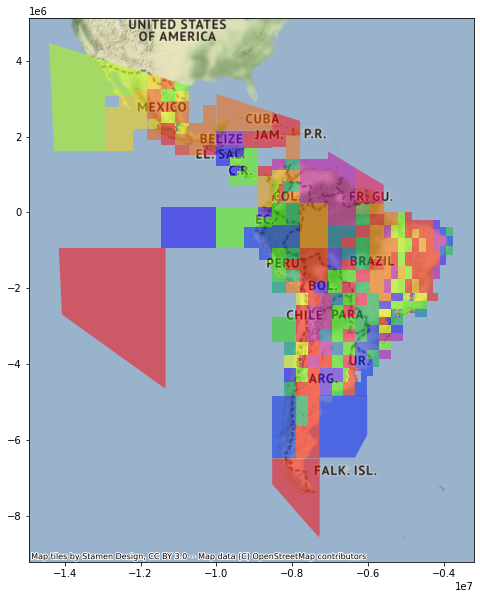

In [884]:
logger.info('map')
cm_read = '2021100301601633066162'
pdf_path = f"{path_s3}/geo_partition/figures/map_distribution_{cm_read}.pdf"
with PdfPages(pdf_path) as pdf:
    tab = gpd.GeoDataFrame(df_geo_partition)
    tab['geometry'] = gpd.GeoSeries.from_wkt(tab['geo_partition_wkt'])
    tab.crs = "EPSG:4326"
    tab = tab.to_crs(epsg=3857)
    ax = tab.plot(figsize=(10, 10), alpha=0.5, 
                  column='group',legend=False, cmap='prism')
    ctx.add_basemap(ax)

In [885]:
df_geo_partition.head()

,group,geo_partition_wkt,share_jams,geometry
0,01,MULTIPOLYGON ( ((-101.8926651563943 -38.495648...,0.014745,"MULTIPOLYGON (((-101.89267 -38.49565, -126.421..."
1,02,"MULTIPOLYGON ( ((-103.03175 19.28787871700466,...",0.014869,"MULTIPOLYGON (((-103.03175 19.28788, -103.0317..."
2,03,MULTIPOLYGON ( ((-103.44459765625 20.501124397...,0.014803,"MULTIPOLYGON (((-103.44460 20.50112, -103.8574..."
3,04,MULTIPOLYGON ( ((-109.6373125 28.9938441623589...,0.008435,"MULTIPOLYGON (((-109.63731 28.99384, -109.6373..."
4,05,MULTIPOLYGON ( ((-33.67334375 -10.041085286949...,0.010849,"MULTIPOLYGON (((-33.67334 -10.04109, -35.32473..."


### Remove intersection

In [888]:
from shapely.geometry import Polygon


In [890]:
# Differences
polygon_list_A = polygon_to_multipolygon(df_final.geo_id)
polygon_la = 'POLYGON((-129.454 37.238,-90.781 27.311,-67.117 20.333,-68.721 17.506,-23.765 -9.114,-65.601 -60.714,-126.421 -23.479,-129.454 37.238))'
differences = list()
for polygon in df_final.geo_id:
    polygon1 = wkt.loads(polygon_la)
    polygon2 = wkt.loads(polygon)
    differences.append(polygon1-polygon2)

# Intersection of differences
differences_int = differences[0]
for k in range(1, len(differences)):
    polygon1 = differences_int
    polygon2 = differences[k]
    dif = (polygon1.intersection(polygon2))
    differences_int = (polygon1.intersection(polygon2))
    
# Only polygons    
polygons = list()
for s in differences_int.wkt.split("), "):
    if s.find('POLYGON') != -1:
        polygons.append(s + ') ')        

polygon_diff = polygon_to_multipolygon(polygons)      

# New definition of difference
dic_diff = {'group': '999', 'geo_partition_wkt':polygon_diff, 'share_jams':0, 'geometry':None}
df_geo_partition = df_geo_partition.append(dic_diff, ignore_index=True)


2021-10-03 23:47:14.874 | INFO     | __main__:<module>:1 - map


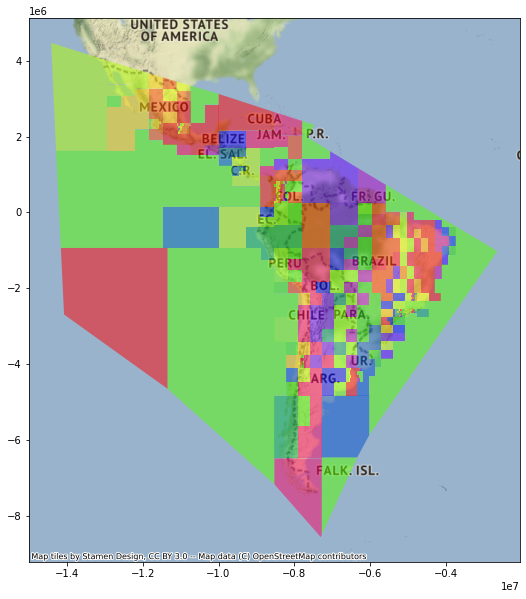

In [891]:
logger.info('map')
cm = '2021100323101633318356'#str(datetime.today().strftime("%Y%m%d%H%m%s"))
pdf_path = f"{path_s3}/geo_partition/figures/map_distribution_{cm}.pdf"
with PdfPages(pdf_path) as pdf:
    df = gpd.GeoDataFrame(df_geo_partition)
    df['geometry'] = gpd.GeoSeries.from_wkt(df['geo_partition_wkt'])
    df.crs = "EPSG:4326"
    df = df.to_crs(epsg=3857)
    ax = df.plot(figsize=(10, 10), alpha=0.5, 
                  column='group',legend=False, cmap='prism')
    ctx.add_basemap(ax)

In [892]:
path_s3
df_geo_partition.to_csv(f'{path_s3}/geo_partition/dist/distribution_{cm}.csv', index=False)